In [185]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
import math


# Preprocessing

In [186]:
train = pd.read_csv('datafiles/train.dat', sep = ' ', header = 0)

# all indices in the training set 
index = train.index

# split the training set indices into training and validation set indices 
training_indices, val_indices = train_test_split(index, test_size = 0.1, random_state = 42)

# write validation indices to a text file for static evaluation 
val_indices_list = val_indices.tolist()

# go through the training data and place each of the corresponding ratings for the validation set into a separate list 
val_ratings = [] 
for index in val_indices: 
    rating = train.loc[index, 'rating']
    val_ratings.append(rating) 

# matrix of users and their movie ratings - will be very sparse 
# each row is a user ID, each column is a movie ID 
rating_matrix = train.pivot_table(index = 'userID', columns = 'movieID', values = 'rating', fill_value = 0)

# Helper functions

In [187]:
# root mean square error function 
def rmse(predictions, real): 
    errors = (np.array(predictions) - np.array(real)) ** 2
    mse = np.mean(errors)
    rmse = np.sqrt(mse) 
    return rmse 

def movie_average_rating(movieID):
    ratings = train[train['movieID'] == movieID]
    average = ratings['rating'].mean() 
    return average

def user_average_rating(userID):
    ratings = train[train['userID'] == userID]
    average = ratings['rating'].mean() 
    return average 

def global_average_rating():
    index = train.index
    ratings = []
    for idx in index: 
        rating = train.loc[idx, 'rating']
        ratings.append(rating) 

    average = sum(ratings) / len(ratings)
    return average 

def jaccard(x, y): 
    intersection = np.sum(np.minimum(x, y))
    union = np.sum(np.maximum(x, y))
    return intersection / union

# Validation using Collaborative Filtering 

In [188]:
def collaborative_filtering(k_similar_users, similarity_measure):
    # matrix of cosine similarities between each user to every other user 
    # each row is a user ID, each column is a user ID 

    if similarity_measure == 'pearson':
        # Pearson correlation coefficient 
        similarity_matrix = pd.DataFrame(1 - pairwise_distances(rating_matrix, metric = 'correlation'),index = rating_matrix.index, columns = rating_matrix.index)

    elif similarity_measure == 'jaccard':
        # Jaccard similarity measure 
        similarity_matrix = pd.DataFrame(1 - pairwise_distances(rating_matrix, metric = jaccard), index = rating_matrix.index, columns = rating_matrix.index)
    
    else:
        # cosine similarity 
        similarity_matrix = pd.DataFrame(cosine_similarity(rating_matrix),index = rating_matrix.index, columns = rating_matrix.index)
    
    val_predictions = []

    # iterate through the rows in the validation set 
    for index in val_indices: 
        # get the user and the movie for which we need to predict the rating 
        user_id = train.loc[index, 'userID']
        movie_id = train.loc[index, 'movieID']

        if movie_id not in rating_matrix.columns: 
            average = user_average_rating(user_id)
            val_predictions.append(round(average, 1))
            continue

        # get the similar users and sort from most similar to least 
        similar_users = similarity_matrix.loc[user_id].sort_values(ascending = False).index

        # array of the top most similar users to the target user 
        top_k_similar = [] 
        count = 0 
        # get the k most similar users that rated this movie 
        # if they didn't rate this movie, skip them 
        for user in similar_users: 
            if count >= k_similar_users: 
                break 

            if rating_matrix.loc[user, movie_id] != 0 and user != user_id:
                top_k_similar.append(user) 
                count += 1
        
        # get the average of the ratings for this movie from the 3 most similar users 
        rating = round(rating_matrix.loc[top_k_similar, movie_id].mean(), 1)

        # this is incase none of the other users rated this movie so all we can do is just use the user's actual rating 
        if(len(top_k_similar) == 0): 
            rating = rating_matrix.loc[user_id, movie_id]

        val_predictions.append(rating)

    error = rmse(np.array(val_predictions), np.array(val_ratings)) 
    return error

# error = collaborative_filtering(20, 'cosine')
# print(error)

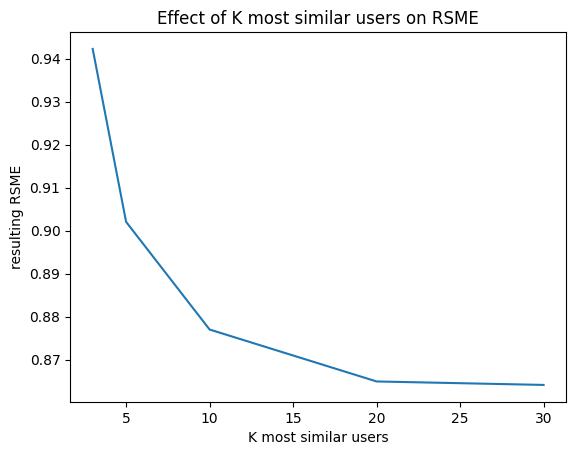

In [190]:
k_values = [3, 5, 10, 20, 30]
errors = [] 

for k in k_values: 
    error = collaborative_filtering(k, 'cosine')
    errors.append(error) 

plt.plot(k_values, errors)
plt.title("Effect of K most similar users on RSME")
plt.xlabel("K most similar users")
plt.ylabel("resulting RSME")
plt.show()

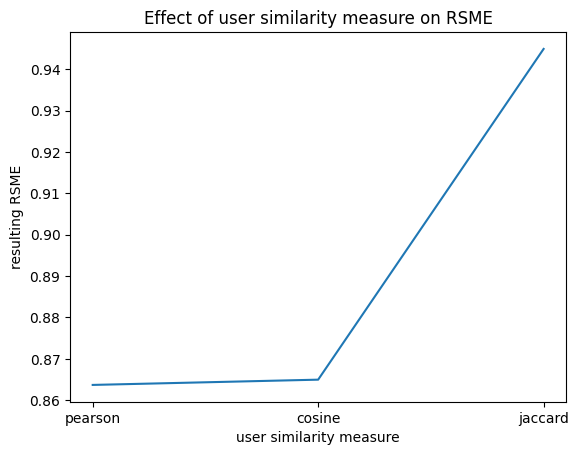

In [191]:
similarity_measures = ['pearson', 'cosine', 'jaccard']
errors = [] 

for measure in similarity_measures: 
    error = collaborative_filtering(20, measure)
    errors.append(error) 

plt.plot(similarity_measures, errors)
plt.title("Effect of user similarity measure on RSME")
plt.xlabel("user similarity measure")
plt.ylabel("resulting RSME")
plt.show()

# Validation using Global Effects

In [183]:
global_avg = global_average_rating() 

val_predictions = []

# iterate through the rows in the validation set 
for index in val_indices: 
    # get the user and the movie for which we need to predict the rating 
    user_id = train.loc[index, 'userID']
    movie_id = train.loc[index, 'movieID']

    if movie_id not in rating_matrix.columns: 
        average = user_average_rating(user_id)
        val_predictions.append(round(average, 1))
        continue

    movie_avg = movie_average_rating(movie_id) 

    # difference between the global average and the movie's average rating 
    movie_mean_diff = global_avg - movie_avg 

    user_avg = user_average_rating(user_id) 

    # difference between the global average and the user's average rating 
    user_mean_diff = global_avg - user_avg 

    rating = movie_avg + movie_mean_diff + user_mean_diff 

    val_predictions.append(rating)

error = rmse(np.array(val_predictions), np.array(val_ratings)) 
print(error) 



1.203874000495276


# Final predictions

In [184]:
# this is the test set without ground truth ratings 
test = pd.read_csv('datafiles/test.dat', sep = ' ', header = 0)

similarity_matrix = pd.DataFrame(1 - pairwise_distances(rating_matrix, metric = 'correlation'),index = rating_matrix.index, columns = rating_matrix.index)

predictions = [] 

for index, row in test.iterrows(): 
    user_id = row['userID']
    movie_id = row['movieID']

    if movie_id not in rating_matrix.columns: 
        average = user_average_rating(user_id)
        predictions.append(round(average, 1))
        continue

    similar_users = similarity_matrix.loc[user_id].sort_values(ascending = False).index
    top_k_similar = [] 
    count = 0 

    for user in similar_users: 
        if count >= 20: 
            break 

        if rating_matrix.loc[user, movie_id] != 0 and user != user_id:
            top_k_similar.append(user) 
            count += 1

    rating = round(rating_matrix.loc[top_k_similar, movie_id].mean(), 1)
    predictions.append(rating)

with open("predictions.txt", 'w') as file: 
    for prediction in predictions: 
        file.write(str(prediction) + "\n")
